# comparison of the insulation score between cell lines and primary cells
this is done in a similar way to the loops

In [5]:
import pandas as pd
import numpy as np
import hicstraw 
from multiprocessing import Pool
from functools import partial
import glob
import os
import plotly.express as px
import math
import matplotlib.pyplot as plt
from matplotlib import colors
from pandarallel import pandarallel
import cooler
import cooltools
import pybedtools as pbed
pandarallel.initialize()
from scipy import stats, special
from statsmodels.stats import multitest
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.io as pio
import seaborn as sns
os.makedirs("/mnt/iusers01/jw01/mdefscs4/scratch/temp_pybedtools/", exist_ok = True)
pbed.helpers.set_tempdir("/mnt/iusers01/jw01/mdefscs4/scratch/temp_pybedtools/")
bed_genome_file = "/mnt/iusers01/jw01/mdefscs4/hg38.genome"

plt.rcParams['svg.fonttype'] = 'none'

base_dir = "/mnt/jw01-aruk-home01/projects/psa_functional_genomics/PsA_cleaned_analysis"

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [6]:
import sys
sys.path.append(f"{base_dir}/data_functions")
from quantile_norm import quantile_normalize

In [7]:
metadata_hic = pd.read_csv(f"{base_dir}/metadata/cleaned_HiC_metadata.csv", index_col = 0)
# read precomputed tables but add the two cell lines
all_df = {}
for key, row in metadata_hic.iterrows():
    sample = row["folder_name"]
    insulation_table = pd.read_csv(f"{base_dir}/HiC_analysis/insulation_score/ins_tables/{sample}.csv.gz", dtype = {1:str,4:str},index_col = 0)
    all_df[sample] = insulation_table

for sample in ["all_jurkat", "MyLa_all_old_ARIMA"]:
    insulation_table = pd.read_csv(f"{base_dir}/HiC_analysis/insulation_score/ins_tables/{sample}.csv.gz", dtype = {1:str,4:str},index_col = 0)
    all_df[sample] = insulation_table

def merge_dfs(dataframes_dict):
    first_df = list(dataframes_dict.values())[0]
    merged_df = first_df[['chrom', 'start', 'end', 'region']]
    for key, df in dataframes_dict.items():
        merged_df = pd.merge(merged_df, df[['chrom', 'start', 'end', 'region', 'log2_insulation_score_100000']], on=['chrom', 'start', 'end', 'region'])
        col = df['log2_insulation_score_100000'].name
        merged_df = merged_df.rename(columns={col: key})
    return merged_df

merged_df = merge_dfs(all_df)

# apply quantile normalization to the insulation scores across samples
merged_df.iloc[:,4:] = quantile_normalize(merged_df.iloc[:,4:])
merged_df["chrom"] = "chr" + merged_df["chrom"] 

In [20]:
# melt the loop dataframe and add info about the cell type from the metadata
merged_df = merged_df.dropna()
ins_scores_melted = pd.melt(merged_df, id_vars=['chrom', 'start', 'end', 'region'], 
        value_vars=merged_df.columns.difference(['chrom', 'start', 'end', 'region']),
        var_name="sample",value_name="ins_score")
df = metadata_hic[["folder_name","cell_type"]].copy()
df = pd.concat([df,pd.DataFrame({"folder_name" : ["all_jurkat","MyLa_all_old_ARIMA"], "cell_type" : ["CD4", "CD8"]})], ignore_index= True)
ins_scores_melted = ins_scores_melted.merge(df, left_on = "sample", right_on = "folder_name", how = "left")

In [23]:
len(merged_df)

113350

In [21]:
def retrieve_pvals_CD4(df):
    val_CD4 = df[(df["cell_type"] == "CD4")]
    z_scores_CD4 = stats.zscore(val_CD4["ins_score"].values)
    p_values_CD4 = stats.norm.pdf(abs(z_scores_CD4))*2 # two sided
    return pd.Series(dict(zip(val_CD4["sample"], p_values_CD4)))

def retrieve_pvals_CD8(df):
    val_CD8 = df[(df["cell_type"] == "CD8")]
    z_scores_CD8 = stats.zscore(val_CD8["ins_score"].values)
    p_values_CD8 = stats.norm.pdf(abs(z_scores_CD8))*2 # two sided
    return pd.Series(dict(zip(val_CD8["sample"], p_values_CD8)))

df_CD4 = ins_scores_melted.groupby(['chrom', 'start', 'end']).parallel_apply(retrieve_pvals_CD4)
df_CD8 = ins_scores_melted.groupby(['chrom', 'start', 'end']).parallel_apply(retrieve_pvals_CD8)

/mnt/iusers01/jw01/mdefscs4/communal_software/new_basic_software/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 30.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/iusers01/jw01/mdefscs4/scratch/temp_pybedtools//ipykernel_13099/3735814926.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


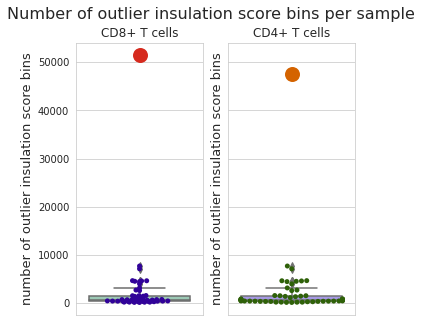

In [22]:
da = df_CD8[df_CD8 < 0.05].count()
da = metadata_hic.merge(da.to_frame(),right_index = True, left_on = "folder_name", how = "right")
da.loc[da["folder_name"] == "MyLa_all_old_ARIMA","cell_type"] = "MyLa"
vals = da[da["cell_type"] != "MyLa"][0]

sns.set_style("whitegrid")
fig, axes = plt.subplots(1,2, figsize = (5,5),sharey=True)
sns.swarmplot(y = vals,ax=axes[0],color="#310299")
sns.boxplot(y = vals,ax=axes[0], color="#94d1b6")
sns.swarmplot(y = da[da["cell_type"] == "MyLa"][0],ax=axes[0],color="#d62a1e", size = 15)


da = df_CD4[df_CD4 < 0.05].count()
da = metadata_hic.merge(da.to_frame(),right_index = True, left_on = "folder_name", how = "right")
da.loc[da["folder_name"] == "all_jurkat","cell_type"] = "Jurkat"
sns.swarmplot(y = vals,ax=axes[1],color="#2f6109")
sns.boxplot(y = vals,ax=axes[1], color="#9e8df0")
sns.swarmplot(y = da[da["cell_type"] == "Jurkat"][0],ax=axes[1],color="#d46300", size = 15)

axes[0].set_title("CD8+ T cells")
axes[1].set_title("CD4+ T cells")
axes[0].set_ylabel("number of outlier insulation score bins", fontsize = 13)
axes[1].set_ylabel("number of outlier insulation score bins", fontsize = 13)
fig.suptitle("Number of outlier insulation score bins per sample", fontsize = 16)
fig.show()
fig.savefig(f"{base_dir}/HiC_analysis/figures/cell_line_outlier_ins_score.svg")